2020년도 건강검진정보 샘플(1만건) 데이터를 이용히야 최적의 분류 모델을 만들고 평가 결과 및 도출된 인사이트를 보여주시오. 
1. 흥미로운 분류 문제 선정: 종속/독립 변수 선택 
   - 수치 데이터를 범주형으로 변경 가능 (예. 이진 클래스로 변경: 0.5 이상 Y, 0.5 미만 N)
   - 건강검진 데이터에 다른 외부 데이터를 연결해서 이용도 가능
   - 필요한 경우 데이터 전처리 및 파생변수 생성 
2. 최적의 분류 모델 선택 (분류 기법, 파라미터) 및 평가 결과 
   - 적절한 평가 방법 1개 선택 
   - 분류 모델의 종류는 3개 이하로 선택, 수업시간에 배우지 않은 분류 모델도 사용 가능 
3. 분류 모델을 통한 인사이트 도출:  중요 변수 설명 등  
4. 코드는 github에 올리고 주소 제출

## 전처리

In [1]:
# 맥북 시각화 한글 오류 해결 
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20170925-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent 

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import train_test_split

In [3]:
from matplotlib import rc

rc('font', family='NanumBarunGothic')
plt.rcParams['axes.unicode_minus'] = False

In [4]:
df = pd.read_csv('health_data.csv')
df.head()

,기준년도,가입자일련번호,시도코드,성별코드,연령대코드(5세단위),신장(5Cm단위),체중(5Kg 단위),허리둘레,시력(좌),시력(우),...,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마지티피,흡연상태,음주여부,구강검진수검여부,치아우식증유무,치석,데이터공개일자
0,2020,1,36,M,9,165,60,72.1,1.2,1.5,...,1.1,21.0,27.0,21.0,No,No,0,NaN,NaN,12/29/2021
1,2020,2,27,F,13,150,65,81.0,0.8,0.8,...,0.5,18.0,15.0,15.0,No,No,0,NaN,NaN,12/29/2021
2,2020,3,11,F,12,155,55,70.0,0.6,0.7,...,0.7,27.0,25.0,7.0,No,No,0,NaN,NaN,12/29/2021
3,2020,4,31,M,13,160,70,90.8,1.0,1.0,...,1.2,65.0,97.0,72.0,No,No,1,0.0,0.0,12/29/2021
4,2020,5,41,F,12,155,50,75.2,1.5,1.2,...,0.7,18.0,17.0,14.0,No,No,0,NaN,NaN,12/29/2021


In [5]:
df.describe(include='all')

,기준년도,가입자일련번호,시도코드,성별코드,연령대코드(5세단위),신장(5Cm단위),체중(5Kg 단위),허리둘레,시력(좌),시력(우),...,혈청크레아티닌,(혈청지오티)AST,(혈청지오티)ALT,감마지티피,흡연상태,음주여부,구강검진수검여부,치아우식증유무,치석,데이터공개일자
count,10000.0,10000.00000,10000.000000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,9912.000000,9912.00000,9912.000000,9912.000000,9998,9999,10000.000000,3251.000000,3251.000000,10000
unique,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3,2,NaN,NaN,NaN,1
top,NaN,NaN,NaN,M,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,No,Yes,NaN,NaN,NaN,12/29/2021
freq,NaN,NaN,NaN,5138,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,6231,5819,NaN,NaN,NaN,10000
mean,2020.0,5000.50000,34.100100,NaN,11.931400,160.983500,63.034500,82.366100,0.933750,0.936750,...,0.848484,27.58979,26.789851,38.098668,NaN,NaN,0.325100,0.175331,0.579514,NaN
std,0.0,2886.89568,12.394581,NaN,2.166048,9.211608,12.205294,9.561973,0.662057,0.641378,...,0.301012,17.88442,23.735687,58.184579,NaN,NaN,0.468436,0.380308,0.591269,NaN
min,2020.0,1.00000,11.000000,NaN,9.000000,130.000000,30.000000,53.000000,0.100000,0.100000,...,0.050000,3.00000,2.000000,3.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN
25%,2020.0,2500.75000,27.000000,NaN,10.000000,155.000000,55.000000,76.000000,0.700000,0.700000,...,0.700000,20.00000,16.000000,16.000000,NaN,NaN,0.000000,0.000000,0.000000,NaN
50%,2020.0,5000.50000,41.000000,NaN,12.000000,160.000000,60.000000,82.000000,0.900000,0.900000,...,0.800000,24.00000,21.000000,24.000000,NaN,NaN,0.000000,0.000000,1.000000,NaN
75%,2020.0,7500.25000,44.000000,NaN,13.000000,170.000000,70.000000,88.900000,1.200000,1.200000,...,1.000000,30.00000,31.000000,39.000000,NaN,NaN,1.000000,0.000000,1.000000,NaN


In [6]:
# 데이터 프레임 데이터 개수, 열 개수 확인
df.shape

(10000, 31)

In [7]:
# 변수별 Data type 확인
# 성별코드, 흡연상태, 음주여부, 데이터 공개 일자의 데이터 타입을 바꾸여야 할 필요가 있어 보임.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   기준년도         10000 non-null  int64  
 1   가입자일련번호      10000 non-null  int64  
 2   시도코드         10000 non-null  int64  
 3   성별코드         10000 non-null  object 
 4   연령대코드(5세단위)  10000 non-null  int64  
 5   신장(5Cm단위)    10000 non-null  int64  
 6   체중(5Kg 단위)   10000 non-null  int64  
 7   허리둘레         10000 non-null  float64
 8   시력(좌)        10000 non-null  float64
 9   시력(우)        10000 non-null  float64
 10  청력(좌)        10000 non-null  int64  
 11  청력(우)        10000 non-null  int64  
 12  수축기혈압        9912 non-null   float64
 13  이완기혈압        9912 non-null   float64
 14  식전혈당(공복혈당)   9912 non-null   float64
 15  총콜레스테롤       4044 non-null   float64
 16  트리글리세라이드     4044 non-null   float64
 17  HDL콜레스테롤     4044 non-null   float64
 18  LDL콜레스테롤     3977 non-null   float64
 19  혈색소  

In [8]:
# 성별 코드 M:0 F:1 로 각각 할당한다. 

ser_sex = []

for i in range(df.shape[0]):
  if df.성별코드[i] == 'M':
    ser_sex.append(0)
  elif df.성별코드[i] == 'F':
    ser_sex.append(1)

df['성별코드'] = ser_sex
df['성별코드']

0       0
1       1
2       1
3       0
4       1
       ..
9995    1
9996    1
9997    0
9998    1
9999    1
Name: 성별코드, Length: 10000, dtype: int64

In [9]:
# 흡연 상태 No:0 Notnow:1 Yes:2 로 각각 할당해준다. 

ser_smoke = []

for i in range(df.shape[0]):
  if df.흡연상태[i] == 'No':
    ser_smoke.append(0)
  elif df.흡연상태[i] == 'NotNow':
    ser_smoke.append(1)
  elif df.흡연상태[i] == 'Yes':
    ser_smoke.append(2)
  else:
    ser_smoke.append(np.nan)

df['흡연상태'] = ser_smoke
df['흡연상태']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
9995    0.0
9996    0.0
9997    0.0
9998    0.0
9999    1.0
Name: 흡연상태, Length: 10000, dtype: float64

In [10]:
# 흡연상태 결측치 개수 확인
df['흡연상태'].isna().sum()

2

In [11]:
# 음주여부 No:0, Yes:1 로 각각 할당

ser_drink = []

for i in range(df.shape[0]):
  if df.음주여부[i] == 'No':
    ser_drink.append(0)
  elif df.음주여부[i] == 'Yes':
    ser_drink.append(1)
  else:
    ser_drink.append(np.nan)

df['음주여부'] = ser_drink
df['음주여부']

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
9995    1.0
9996    1.0
9997    0.0
9998    0.0
9999    1.0
Name: 음주여부, Length: 10000, dtype: float64

In [12]:
# 음주여부 결측치 개수 확인
df['음주여부'].isna().sum()

1

In [13]:
# 데이터 공개일자는 datetime 타입으로 바꿔준다. 
df['데이터공개일자']=pd.to_datetime(df['데이터공개일자'])

In [14]:
df['데이터공개일자']

0      2021-12-29
1      2021-12-29
2      2021-12-29
3      2021-12-29
4      2021-12-29
          ...    
9995   2021-12-29
9996   2021-12-29
9997   2021-12-29
9998   2021-12-29
9999   2021-12-29
Name: 데이터공개일자, Length: 10000, dtype: datetime64[ns]

In [15]:
# 성별코드, 흡연상태, 음주여부는 integer 타입으로, 데이터 공개 일자는 datetime 타입으로 변한 것을 확인 할 수 있음.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   기준년도         10000 non-null  int64         
 1   가입자일련번호      10000 non-null  int64         
 2   시도코드         10000 non-null  int64         
 3   성별코드         10000 non-null  int64         
 4   연령대코드(5세단위)  10000 non-null  int64         
 5   신장(5Cm단위)    10000 non-null  int64         
 6   체중(5Kg 단위)   10000 non-null  int64         
 7   허리둘레         10000 non-null  float64       
 8   시력(좌)        10000 non-null  float64       
 9   시력(우)        10000 non-null  float64       
 10  청력(좌)        10000 non-null  int64         
 11  청력(우)        10000 non-null  int64         
 12  수축기혈압        9912 non-null   float64       
 13  이완기혈압        9912 non-null   float64       
 14  식전혈당(공복혈당)   9912 non-null   float64       
 15  총콜레스테롤       4044 non-null   float64       
 16  트리글리세

In [16]:
# 결측값들을 평균값으로 대치
df2 = df.fillna(df.mean())
df2.isnull().sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  


기준년도           0
가입자일련번호        0
시도코드           0
성별코드           0
연령대코드(5세단위)    0
신장(5Cm단위)      0
체중(5Kg 단위)     0
허리둘레           0
시력(좌)          0
시력(우)          0
청력(좌)          0
청력(우)          0
수축기혈압          0
이완기혈압          0
식전혈당(공복혈당)     0
총콜레스테롤         0
트리글리세라이드       0
HDL콜레스테롤       0
LDL콜레스테롤       0
혈색소            0
요단백            0
혈청크레아티닌        0
(혈청지오티)AST     0
(혈청지오티)ALT     0
감마지티피          0
흡연상태           0
음주여부           0
구강검진수검여부       0
치아우식증유무        0
치석             0
데이터공개일자        0
dtype: int64

## Clustering 분석

In [17]:
# 피쳐 선택
feature = df2[['(혈청지오티)ALT','(혈청지오티)AST', '신장(5Cm단위)', '체중(5Kg 단위)', '허리둘레', '수축기혈압', '이완기혈압', '식전혈당(공복혈당)', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '요단백', '혈청크레아티닌', '감마지티피']]

In [18]:
# y 변수로 총콜레스테롤 선택, x는 y를 뺀 나머지로 선택.
# 총콜레스테롤이 정상 수치 기준인 240 mg/dl 을 넘으면 1, 넘지 않고 정상이면 0.

y = df2['총콜레스테롤']
y = np.where(y < 240, 0, 1)
y = pd.DataFrame(y)
x = df2[['(혈청지오티)ALT','(혈청지오티)AST', '신장(5Cm단위)', '체중(5Kg 단위)', '허리둘레', '수축기혈압', '이완기혈압', '식전혈당(공복혈당)', '트리글리세라이드', 'HDL콜레스테롤', 'LDL콜레스테롤', '혈색소', '요단백', '혈청크레아티닌', '감마지티피', '기준년도', '가입자일련번호', '시도코드', '성별코드', '연령대코드(5세단위)', '시력(좌)', '시력(우)', '청력(좌)', '청력(우)', '흡연상태', '음주여부', '구강검진수검여부', '치아우식증유무','치석']]

In [19]:
# train set, test set 데이터 나누기
x_train, x_test, y_train, y_test = train_test_split(
     x, y, test_size=0.33, random_state=0
 )

### (1) 랜덤포레스트

In [20]:
# Gridsearch로 최적의 parameter 찾기 (랜덤포레스트)
grid = {
    'max_depth' : [2,3,4,5,6],
    'max_features' : [3,4,5,6,7,8,9]
}
rf_cv = GridSearchCV(estimator=RandomForestRegressor(), param_grid=grid, cv= 5, n_jobs=-1)
rf_cv.fit(x_train, y_train)
print(rf_cv.best_params_)
print(rf_cv.best_score_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'max_depth': 6, 'max_features': 9}
0.7361056672841642


In [21]:
# 랜덤포레스트 random forest
regressor = RandomForestRegressor(random_state=0, max_depth=6, max_features=9) # gridsearch로 찾은 파라미터 옵션값으로 넣어주기
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)

#ROC and AUC 점수
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
print("AUC score: ", round(metrics.auc(fpr, tpr),3))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


AUC score:  0.996


### (2) 의사결정나무

In [22]:
# Gridsearch로 최적의 parameter 찾기 (의사결정나무)
grid = {
    'max_depth' : [2,3,4,5,6],
    'max_features' : [3,4,5,6,7,8,9]
}
rf_cv = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=grid, cv= 5, n_jobs=-1)
rf_cv.fit(x_train, y_train)
print(rf_cv.best_params_)
print(rf_cv.best_score_)

{'max_depth': 4, 'max_features': 9}
0.9683582089552238


In [23]:
#decsion tree 의사결정나무
clf = DecisionTreeClassifier(max_depth=4, max_features=9) # gridsearch로 찾은 파라미터 옵션값으로 넣어주기
clf = clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)

print("혼동행렬")
print(metrics.confusion_matrix(y_test, y_pred))
#ROC and AUC
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
print("AUC score: ", round(metrics.auc(fpr, tpr),3))

혼동행렬
[[3038   49]
 [  75  138]]
AUC score:  0.816


### (3) Extra Tree Classifier

In [24]:
# Gridsearch로 최적의 parameter 찾기 (Extra Tree Classifier)
grid = {
    'max_depth' : [2,3,4,5,6],
    'max_features' : [3,4,5,6,7,8,9]
}
rf_cv = GridSearchCV(estimator=ExtraTreesClassifier(), param_grid=grid, cv= 5, n_jobs=-1)
rf_cv.fit(x_train, y_train)
print(rf_cv.best_params_)
print(rf_cv.best_score_)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'max_depth': 6, 'max_features': 9}
0.9411940298507464


In [25]:
# Extra Tree Classifier
extratree = ExtraTreesClassifier(max_depth=6, max_features=9) # gridsearch로 찾은 파라미터 옵션값으로 넣어주기
extratree.fit(x_train, y_train)
y_pred = extratree.predict(x_test)

print("혼동행렬")
print(metrics.confusion_matrix(y_test, y_pred))
#ROC and AUC
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
print("AUC score: ", round(metrics.auc(fpr, tpr),3))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


혼동행렬
[[3087    0]
 [ 199   14]]
AUC score:  0.533


### Feature Importance

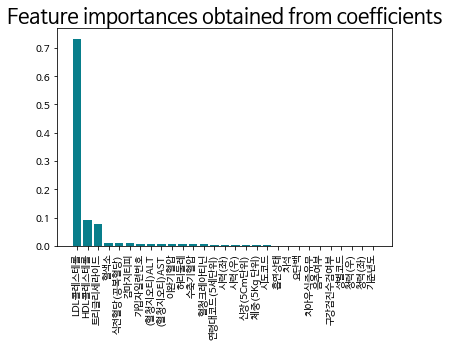

In [26]:
# 변수 중요도 그래프로 보기
# 총콜레스테롤에 영향을 많이 미치는 변수는 LDL 콜레스테롤, HDL 콜레스테롤, 트리글레세라이드 등이 있고, 그 뒤는 혈색소가 약간의 영향을 미치는 것으로 보인다.
# 총콜레스테롤이 정상 수치인지 아닌지를 판별할 때 LDL 콜레스테롤이 가장 큰 영향을 미친다. 

importances = pd.DataFrame(data={
    'Attribute': x_train.columns,
    'Importance': regressor.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()